### Imports

In [1]:
import numpy as np
from numpy import pi, cos, sin, array, exp, sqrt, log10

In [2]:
from scipy import signal

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=3, suppress=True)

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

### Modulation and Demodulation

In [5]:
N = 8 # Seq length
symbols = array([1-1j, -1+1j, 1+1j, -1+1j, 1-1j, 1+1j, -1-1j, -1+1j])/sqrt(2)

# Modulation
idft_out = np.zeros_like(symbols)
for n in np.arange(N):
    m = np.arange(N)
    tones = exp(2j*pi*n*m/N)
    idft_out[n] = np.dot(symbols, tones)
    
guard = idft_out[-2:]
ofdm_symbol = np.concatenate((guard, idft_out))

# Demodulation
dft_out = np.zeros_like(symbols)
ofdm_symbol_no_guard = ofdm_symbol[len(guard):]
for m in np.arange(N):
    n = np.arange(N)
    tone = exp(-2j*pi*n*m/N)
    dft_out[m] = np.dot(ofdm_symbol_no_guard, tone)/N
    
dft_out * sqrt(2)

array([ 1.-1.j, -1.+1.j,  1.+1.j, -1.+1.j,  1.-1.j,  1.+1.j, -1.-1.j,
       -1.+1.j])

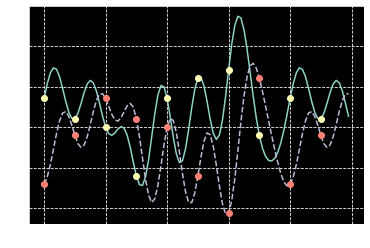

In [6]:
nn = np.arange(-2, N, 0.1)
waveform = np.zeros_like(nn, complex)
for m in np.arange(N):
    tone = exp(2j*pi*nn*m/N)
    waveform += symbols[m]*tone

# Somehow the waveform does not match the one shown in book
plt.plot(nn, waveform.real, np.arange(-2,N), ofdm_symbol.real, 'o')
plt.plot(nn, waveform.imag, '--', np.arange(-2,N), ofdm_symbol.imag, 'o')
plt.grid(ls='dashed')